In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils, probeReadWrite
from pyCascade.probeReadWrite import read_probes_file_switch
from filloutVentilationStats import *
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from cycler import cycler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import statsmodels.api as sm
import warnings

plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

In [3]:
hm = 6
window_dim = hm/2/4
velTenMeters = 1 #4
T_ref = 5
Cp = 1005

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
       ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}

roomkey = {
    "0-0": "corner",
    "1-0": "single",
    "2-0": "cross",
    "1-1": "dual",
    "2-1": "cross-DUPLICATE",
    "0-1": "dual-DUPLICATE"
}

x = 4
y = 3
wall_area = x*y
floor_area = x*x
window_area = (.25*y)**2
door_area = (0.25*y) * (0.75*y)

room_areas = {
    "walls": {
        "single": 4*wall_area - window_area,
        "corner": 4*wall_area - 2*window_area,
        "dual": 8*wall_area - 3*window_area - door_area,
        "cross": 6*wall_area - 2*window_area,
    },
    "floors": {
        "single": floor_area,
        "corner": floor_area,
        "dual": 2 * floor_area,
        "cross": 2 * floor_area,
    },
    "ceilings": {
        "single": floor_area - window_area,
        "corner": floor_area - window_area,
        "dual": 2 * (floor_area - window_area),
        "cross": 2 * (floor_area - window_area),
    }
}

In [4]:
runs = {
    # 234: {'B': False, 'detT': 0, 'A': 0,  'WS': 4, 'C': 2},
    # 233: {'B': False, 'detT': 0, 'A': 45, 'WS': 4, 'C': 2},
    # 236: {'B': False, 'detT': 0, 'A': 0,  'WS': 2, 'C': 2},
    # 221: {'B': True,  'detT': 4, 'A': 0,  'WS': 4, 'C': 2},
    # 222: {'B': False, 'detT': 0, 'A': 45, 'WS': 2, 'C': 2},
    # 223: {'B': True,  'detT': 4, 'A': 0,  'WS': 2, 'C': 2},
    # 224: {'B': True,  'detT': 4, 'A': 45, 'WS': 2, 'C': 2},
    # 225: {'B': True,  'detT': 4, 'A': 45, 'WS': 4, 'C': 2},
    # 227: {'B': True,  'detT': 4, 'A': 45, 'WS': 6, 'C': 2},
    # 228: {'B': True,  'detT': 4, 'A': 0,  'WS': 6, 'C': 2},
    # 229: {'B': False, 'detT': 0, 'A': 0,  'WS': 6, 'C': 2},
    # 230: {'B': False, 'detT': 0, 'A': 45, 'WS': 6, 'C': 2},
    # 305: {'B': False, 'detT': 0, 'A': 0,  'WS': 4, 'C': 3},
    # 306: {'B': False, 'detT': 0, 'A': 45, 'WS': 4, 'C': 3},
    # 307: {'B': False, 'detT': 0, 'A': 0,  'WS': 2, 'C': 3},
    # 308: {'B': False, 'detT': 0, 'A': 45, 'WS': 2, 'C': 3},
}


# runs = {
#     221: {'B': True,  'delT': 4, 'delTPart': 2,  'A': 0, 'WS': 4, 'C': 2},
#     234: {'B': False, 'delT': 0, 'delTPart': 0,  'A': 0, 'WS': 4, 'C': 2},
#     235: {'B': True,  'delT': 1, 'delTPart': .5, 'A': 0, 'WS': 2, 'C': 2},
#     237: {'B': True,  'delT': 1, 'delTPart': 1,  'A': 0, 'WS': 2, 'C': 2},
#     236: {'B': False, 'delT': 0, 'delTPart': 0,  'A': 0, 'WS': 2, 'C': 2},
#     225: {'B': True,  'delT': 4, 'delTPart': 2,  'A': 45,'WS': 4, 'C': 2},
#     233: {'B': False, 'delT': 0, 'delTPart': 0,  'A': 45,'WS': 4, 'C': 2},
#     239: {'B': True,  'delT': 1, 'delTPart': .5, 'A': 45,'WS': 2, 'C': 2},
#     238: {'B': True,  'delT': 1, 'delTPart': 1,  'A': 45,'WS': 2, 'C': 2},
#     222: {'B': False, 'delT': 0, 'delTPart': 0,  'A': 45,'WS': 2, 'C': 2},
#     311: {'B': True,  'delT': 4, 'delTPart': 2,  'A': 0, 'WS': 4, 'C': 3},
#     305: {'B': False, 'delT': 0, 'delTPart': 0,  'A': 0, 'WS': 4, 'C': 3},
#     312: {'B': True,  'delT': 1, 'delTPart': .5, 'A': 0, 'WS': 2, 'C': 3},
#     # 237: {'B': True,  'delT': 1, 'delTPart': 1,  'A': 0, 'WS': 2, 'C': 3},
#     307: {'B': False, 'delT': 0, 'delTPart': 0,  'A': 0, 'WS': 2, 'C': 3},
#     309: {'B': True,  'delT': 4, 'delTPart': 2,  'A': 45,'WS': 4, 'C': 3},
#     306: {'B': False, 'delT': 0, 'delTPart': 0,  'A': 45,'WS': 4, 'C': 3},
#     310: {'B': True,  'delT': 1, 'delTPart': .5, 'A': 45,'WS': 2, 'C': 3},
#     # 238: {'B': True,  'delT': 1, 'delTPart': 1,  'A': 45,'WS': 2, 'C': 3},
#     313: {'B': False, 'delT': 0, 'delTPart': 0,  'A': 45,'WS': 2, 'C': 3},
#     # 304: {'B': False, 'delT': 0, 'delTPart': 0,  'A': 45,'WS': 2, 'C': 3},
# }

runs = {
    253: {'A': 45, 'WS': 2, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    254: {'A': 45, 'WS': 4, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    255: {'A': 0,  'WS': 2, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    256: {'A': 0,  'WS': 4, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
}

plotFolder = f"{home_dir}/CHARLES/multiPlots/"
# plotFolder = f"{home_dir}/CHARLES/multiPlots/quickRiCompare/"

In [5]:
def string_to_list(s):
    # Check if the string contains square brackets and remove them if present
    if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
        s = s.strip('[]')
        l = s.split()
        l = [s.replace(',','') for s in l]
        return [float(s) for s in l]
    else:
        return s

def indexPlusB(name):
    name_parts = name.split(("_"))
    if 'B' not in name_parts[-1]:
        name_parts.append('B')
    return '_'.join(name_parts)
    

def room_numbers_to_names(name, roomkey = roomkey):
    name = indexPlusB(name)
    name_parts = name.split(("_"))
    if name_parts[1] not in roomkey:
        raise Exception(f"room number not in room key")
    else:
        name_parts[1] = roomkey[name_parts[1]]
    return '_'.join(name_parts[1:])

def splitRoomStats(df):
    df['splitCol'] = df.index.map(lambda x: x.split('_')[0])
    df.index = df.index.map(room_numbers_to_names)
    splitVals = set(df['splitCol'])
    dfs = []

    for val in splitVals:
        split_df = df[df['splitCol'] == val].copy()
        split_df = split_df.drop(columns=['splitCol'])
        split_df.columns = [f"{c}-{val}" for c in split_df.columns]
        dfs.append(split_df)
    
    df = pd.concat(dfs, axis = "columns")
    return df


def norm_Temp(df, T_ref = T_ref):
    return df / T_ref



In [6]:

allFlowStats = {}
allRoomVentilation = {}
allFluxStats = {}
allVolStats = {}
allRoomVolStats = {}

for run in runs:
    C = runs[run]['C']
    category = f"config{C}"
    R = run % 100
    probes_dir = f'{home_dir}/CHARLES/{category}/R{R}/probes/probesOut_parquet'
    locations_dir = f'{scratch_dir}/CHARLES/{category}/R{R}/probes/locations'
    print(probes_dir)
    starts = runs[run]['starts']
    stops = runs[run]['stops']
    delT = runs[run]['starts']
    SS = runs[run]['SS']
    if len(set([len(starts), len(stops), len(delT), len(SS)])) != 1:
        raise Exception(f"Run {runs} has array properties of different lengths")
    for j, start in enumerate(starts):
        stop = stops[j]
        flowStatsPath = f"{probes_dir}/../flowStats-{start}to{stop}.csv"
        fluxStatsPath = f"{probes_dir}/../roomFluxStats-{start}to{stop}.csv" 
        volStatsPath = f"{probes_dir}/../volStats-{start}to{stop}.csv" 
        roomVolStatsPath = f"{probes_dir}/../roomVolStats-{start}to{stop}.csv" 
        paths = [flowStatsPath, fluxStatsPath, volStatsPath, roomVolStatsPath]
        for path in paths:
            if os.path.exists(path) == False:
                warnings.warn(f"Run {run} from steps {start} to {stop} does not has associated ventilation file {path} Run createVentilationStats.slurm from run folder first.")

        flowStats = pd.read_csv(flowStatsPath, index_col=0)
        runParams = []
        for k, v in runs[run].items():
            runParams.append(k)
            if isinstance(v, list):
                flowStats[k] = v[j]
            else:
                flowStats[k] = v

        roomQois = ["EP_normal", "EP_shear", "EPR_mag", "EP_mag"]
        roomQois += runParams
        roomQois += [q for q in flowStats.columns.values if 'net-' in q or 'mean-' in q]
        roomQois.append("rms-sn_prod(p)")
        roomQois += ['x', 'y', 'z', 'openingType', 'windowNumber']

        sort_order = ["blockType", "houseType", "roomType"]
        roomVentilation = roomStatistics(flowStats, connectedWindows, roomQois)

        roomVentilation = roomVentilation.sort_values(by = sort_order)
        sort_order.append("windowType")
        flowStats = flowStats.sort_values(by = sort_order)
        flowStats.index = flowStats.index.map(indexPlusB)

        # room flux probes
        fluxStats = pd.read_csv(fluxStatsPath, index_col=0)
        fluxStats = splitRoomStats(fluxStats)

        volStats = pd.read_csv(volStatsPath, index_col=0)
        volStats = splitRoomStats(volStats)
        volStats = volStats.map(string_to_list)

        roomVolStats = pd.read_csv(roomVolStatsPath, index_col=0)
        roomVolStats = splitRoomStats(roomVolStats)
        roomVolStats = roomVolStats.map(string_to_list)

        runIndex = int(10*run + j)
        
        allFlowStats[runIndex] = flowStats
        allRoomVentilation[runIndex] = roomVentilation
        allFluxStats[runIndex] = fluxStats
        allVolStats[runIndex] = volStats
        allRoomVolStats[runIndex] = roomVolStats

/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R46/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R47/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R48/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R49/probes/probesOut_parquet


In [8]:
flowStatsMI = pd.concat(allFlowStats.values(), keys=allFlowStats.keys())
roomVentilationMI = pd.concat(allRoomVentilation.values(), keys=allRoomVentilation.keys())
fluxStatsMI = pd.concat(allFluxStats.values(), keys=allFluxStats.keys())
volStatsMI = pd.concat(allVolStats.values(), keys=allVolStats.keys())
roomVolStatsMI = pd.concat(allRoomVolStats.values(), keys=allRoomVolStats.keys())

for df in [fluxStatsMI, volStatsMI, roomVolStatsMI]:
    for qoi in df.columns.values:
        if fnmatch(qoi, '*T*'):
            if fnmatch(qoi, "*tau*"):
                df[qoi] = df[qoi].apply(lambda l: [l[0], norm_Temp(l[1])])
            else:
                df[qoi] = df[qoi].apply(norm_Temp)
roomVentilationMI["nWindows"] = roomVentilationMI[roomQois[0]].apply(lambda l: len(l))
roomVentilationMI["contResid"] = roomVentilationMI['mean-mass_flux'].apply(lambda l: np.mean(l))
for qoi in roomQois:
    if fnmatch(qoi, '*mass_flux') or fnmatch(qoi, '*sn_prod(u)') or fnmatch(qoi, '*sn_prod(abs(u))'):  # flow quantities
        roomVentilationMI[qoi] = roomVentilationMI[qoi].apply(lambda l : sum(np.abs(l))/2)
    if fnmatch(qoi, '*mass_flux(?)') or fnmatch(qoi, '*sn_prod(u**2)') or fnmatch(qoi, 'rms-sn_prod(p)'): # net quantities
        roomVentilationMI[qoi] = roomVentilationMI[qoi].apply(lambda l : sum(l))
    elif fnmatch(qoi, '*sn_prod(p)'):
        # roomVentilationMI[qoi] = roomVentilationMI[qoi].apply(lambda l : sum(l))
        pass
    elif qoi in ['x', 'y', 'z']:
        roomVentilationMI[qoi] = roomVentilationMI[qoi].apply(lambda l : np.mean(l))
    elif qoi in runParams:
        roomVentilationMI[qoi] = roomVentilationMI[qoi].apply(lambda l : l[0])
roomVentilationMI["EPR_mag"] = roomVentilationMI["EPR_mag"].apply(lambda l: np.mean(l))
roomVentilationMI["EP_shear"] = roomVentilationMI["EP_shear"].apply(lambda l: sum(l))
roomVentilationMI["EP_mag"] = roomVentilationMI["EP_mag"].apply(lambda l: sum(l))
roomVentilationMI["EP_normal_mag"] = roomVentilationMI["EP_normal"].apply(lambda l: sum(np.abs(l)))
roomVentilationMI["EP_normal_sum"] = roomVentilationMI["EP_normal"].apply(lambda l: abs(sum(l)))
roomVentilationMI["EP_normal_ratio"] = roomVentilationMI["EP_normal_mag"] / (roomVentilationMI["EP_normal_mag"] + roomVentilationMI["EP_normal_sum"])

flowStatsMI = getWindowOrientations(flowStatsMI)
roomVentilationMI = getRoomOrientations(roomVentilationMI)

flowStatsMI = fillInParams(flowStatsMI, velTenMeters)
roomVentilationMI = fillInParams(roomVentilationMI, velTenMeters)

flowStatsMI["roomA"] = flowStatsMI["roomOrientation"] + flowStatsMI["A"]

roomVentilationMI = pd.concat([roomVentilationMI, fluxStatsMI, volStatsMI, roomVolStatsMI], axis = "columns")

flowStatsMI.to_csv(f'{plotFolder}flowStatsMI.csv')
roomVentilationMI.to_csv(f'{plotFolder}roomVentilationMI.csv')

# flowStatsMI["houseType"].replace(["0--2", "0--1", "0-0", "0-1", "0-2"], ['3-0', '3-1', '3-2', '3-3', '3-4'], inplace = True)
# roomVentilationMI["houseType"].replace(["0--2", "0--1", "0-0", "0-1", "0-2"], ['3-0', '3-1', '3-2', '3-3', '3-4'], inplace = True)


duplicates = roomVentilationMI.index.get_level_values(1).str.contains("DUPLICATE")
roomVentilationMIDuplicates = roomVentilationMI[duplicates]
roomVentilationMI = roomVentilationMI[~duplicates]

scalar = 'S'
calc = "mean"
qoi = f"{calc}-mass_flux({scalar})"

roomVentilationMI[f"{calc}-mass_flux-roomCeil-slEx"] = roomVentilationMI[f"{calc}-mass_flux-roomCeil"]
roomVentilationMI[f"{qoi}-roomCeil-slEx"] = roomVentilationMI[f"{qoi}-roomCeil"]
for index, row in roomVentilationMI.iterrows():
    index_split = index[1].split('_')
    room = index_split[0]
    house_type = index_split[1]

    if house_type == "sl":
        skylight_flow = 0
        skylight_flux = 0
        for window in connectedWindows[room]:
            if "skylight" in window:
                skylight_index = '_'.join([window, *index_split[1:]])
                skylight_flow += flowStatsMI.loc[(index[0], skylight_index), f"{calc}-mass_flux"]
                skylight_flux += flowStatsMI.loc[(index[0], skylight_index), qoi]
        roomVentilationMI[f"{calc}-mass_flux-roomCeil-slEx"][index] += skylight_flow
        roomVentilationMI[f"{qoi}-roomCeil-slEx"][index] += skylight_flux

errorCeil = roomVentilationMI[f"{calc}-mass_flux-roomCeil-slEx"] * roomVentilationMI[f"mean-{scalar}-room5"]
errorFloor = roomVentilationMI[f"{calc}-mass_flux-roomFloor"] * roomVentilationMI[f"mean-{scalar}-room0"]

roomVentilationMI[f"{qoi}-roomCeil-Zeroed"] = roomVentilationMI[f"{qoi}-roomCeil-slEx"] - errorCeil
roomVentilationMI[f"{qoi}-roomFloor-Zeroed"] = roomVentilationMI[f"{qoi}-roomFloor"] - errorFloor

roomVentilationMI[f"{qoi}-roomCeil-Zeroed"] = -roomVentilationMI[f"{qoi}-roomCeil-Zeroed"] # flipping because down is away from ceiling
roomVentilationMI[f"{qoi}-roomWalls-Zeroed"] = -(roomVentilationMI[qoi] + roomVentilationMI[f"{qoi}-roomCeil-Zeroed"] + roomVentilationMI[f"{qoi}-roomFloor-Zeroed"])

roomVentilationMI[f"{qoi}-roomCeil-Norm"] = np.nan
roomVentilationMI[f"{qoi}-roomFloor-Norm"] = np.nan
roomVentilationMI[f"{qoi}-roomWalls-Norm"] = np.nan

for index, row in roomVentilationMI.iterrows():
    index_split = index[1].split('_')
    room = index_split[0]
    house_type = index_split[1]

    if "sl" in house_type:
        ceilA = room_areas["ceilings"][room]
    else:
        ceilA = room_areas["floors"][room]
    roomVentilationMI[f"{qoi}-roomCeil-Norm"][index] = row[f"{qoi}-roomCeil-Zeroed"] / ceilA
    roomVentilationMI[f"{qoi}-roomFloor-Norm"][index] = row[f"{qoi}-roomFloor-Zeroed"] / room_areas["floors"][room]
    roomVentilationMI[f"{qoi}-roomWalls-Norm"][index] = row[f"{qoi}-roomWalls-Zeroed"] / room_areas["walls"][room]

T_in = roomVentilationMI[f"mean-{scalar}-room"]
T_S = 1
for surface in ["roomCeil", "roomFloor", "roomWalls"]:
    col = f"{qoi}-{surface}"
    roomVentilationMI[f"{col}-h"] = Cp * roomVentilationMI[f"{col}-Norm"] / (T_S - T_in)


roomVentilationMI

/tmp/ipykernel_27824/1884553306.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_27824/1884553306.py:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_27824/1884553306.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_27824/1884553306.py:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

EP_normal  \
2460 corner_h_0--1_B                   [0.22489081, 0.6574876689049642]   
     cross_h_0--1_B                    [0.3834934130683409, 0.16693705]   
     dual_h_0--1_B         [-0.1651452514720431, 0.5171127, 0.29623399]   
     single_h_0--1_B                               [0.0323891600112828]   
     corner_h_0--2_B                         [0.10568718, 0.0077075385]   
...                                                                 ...   
2492 single_h_0-2_Bz                               [0.1407662165419083]   
     corner_sl_Bz     [-0.1514360784763533, 0.1215774088241166, 0.20...   
     cross_sl_Bz      [-0.1525219211494101, -0.24322523, 0.33272044,...   
     dual_sl_Bz       [-0.240263598538769, -0.364611993468921, 0.157...   
     single_sl_Bz             [-0.2413964819589514, 0.2507857652639773]   

                      EP_shear   EPR_mag    EP_mag     A   WS    C    starts  \
2460 corner_h_0--1_B  0.553807  1.954994  1.090729  45.0  2.0  2.0   40000.0   
     cross_h_0--1_B   0.369252  1.954994  0.670495  45.0  2.0  2.0   40000.0   
     dual_h_0--1_B    0.733189  1.954994  1.342676  45.0  2.0  2.0   40000.0   
     single_h_0--1_B  0.439181  1.954994  0.440374  45.0  2.0  2.0   40000.0   
     corner_h_0--2_B  3.348654  1.681641  3.351197  45.0  2.0  2.0   40000.0   
...                        ...       ...       ...   ...  ...  ...       ...   
2492 single_h_0-2_Bz  0.108337  2.486651  0.936401   0.0  4.0  2.0  160000.0   
     corner_sl_Bz     4.245254  3.702787  5.717149   0.0  4.0  2.0  160000.0   
     cross_sl_Bz      5.956833  3.702787  7.576240   0.0  4.0  2.0  160000.0   
     dual_sl_Bz       7.881567  3.702787  9.654766   0.0  4.0  2.0  160000.0   
     single_sl_Bz     2.712544  3.702787  3.731646   0.0  4.0  2.0  160000.0   

                         stops  delT  ... mean-mass_flux(S)-roomCeil-slEx  \
2460 corner_h_0--1_B  120000.0   0.0  ...                       -0.019089   
     cross_h_0--1_B   120000.0   0.0  ...                       -0.018398   
     dual_h_0--1_B    120000.0   0.0  ...                       -0.031420   
     single_h_0--1_B  120000.0   0.0  ...                       -0.002535   
     corner_h_0--2_B  120000.0   0.0  ...                       -0.030441   
...                        ...   ...  ...                             ...   
2492 single_h_0-2_Bz  240000.0   5.0  ...                        0.017281   
     corner_sl_Bz     240000.0   5.0  ...                       -0.061240   
     cross_sl_Bz      240000.0   5.0  ...                       -0.413336   
     dual_sl_Bz       240000.0   5.0  ...                       -0.367671   
     single_sl_Bz     240000.0   5.0  ...                       -0.071902   

                      mean-mass_flux(S)-roomCeil-Zeroed  \
2460 corner_h_0--1_B                           0.024325   
     cross_h_0--1_B                            0.020386   
     dual_h_0--1_B                             0.035534   
     single_h_0--1_B                           0.002926   
     corner_h_0--2_B                           0.033601   
...                                                 ...   
2492 single_h_0-2_Bz                           0.001542   
     corner_sl_Bz                              0.166835   
     cross_sl_Bz                               0.315778   
     dual_sl_Bz                                0.082266   
     single_sl_Bz                              0.094692   

                      mean-mass_flux(S)-roomFloor-Zeroed  \
2460 corner_h_0--1_B                            0.028605   
     cross_h_0--1_B                             0.015554   
     dual_h_0--1_B                              0.035332   
     single_h_0--1_B                            0.003033   
     corner_h_0--2_B                            0.037629   
...                                                  ...   
2492 single_h_0-2_Bz                            0.022482   
     corner_sl_Bz                               0.093304   
     cross_sl_Bz          

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `pal

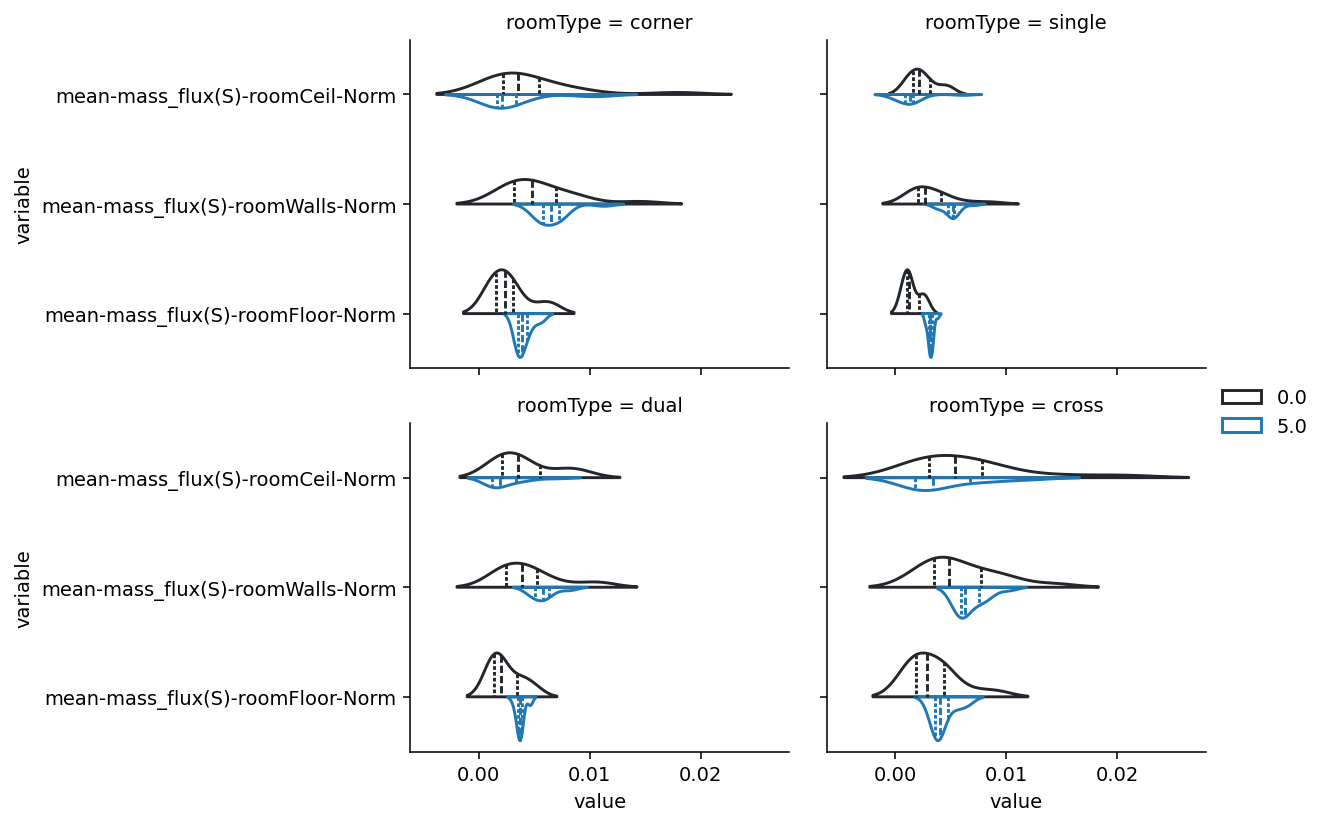

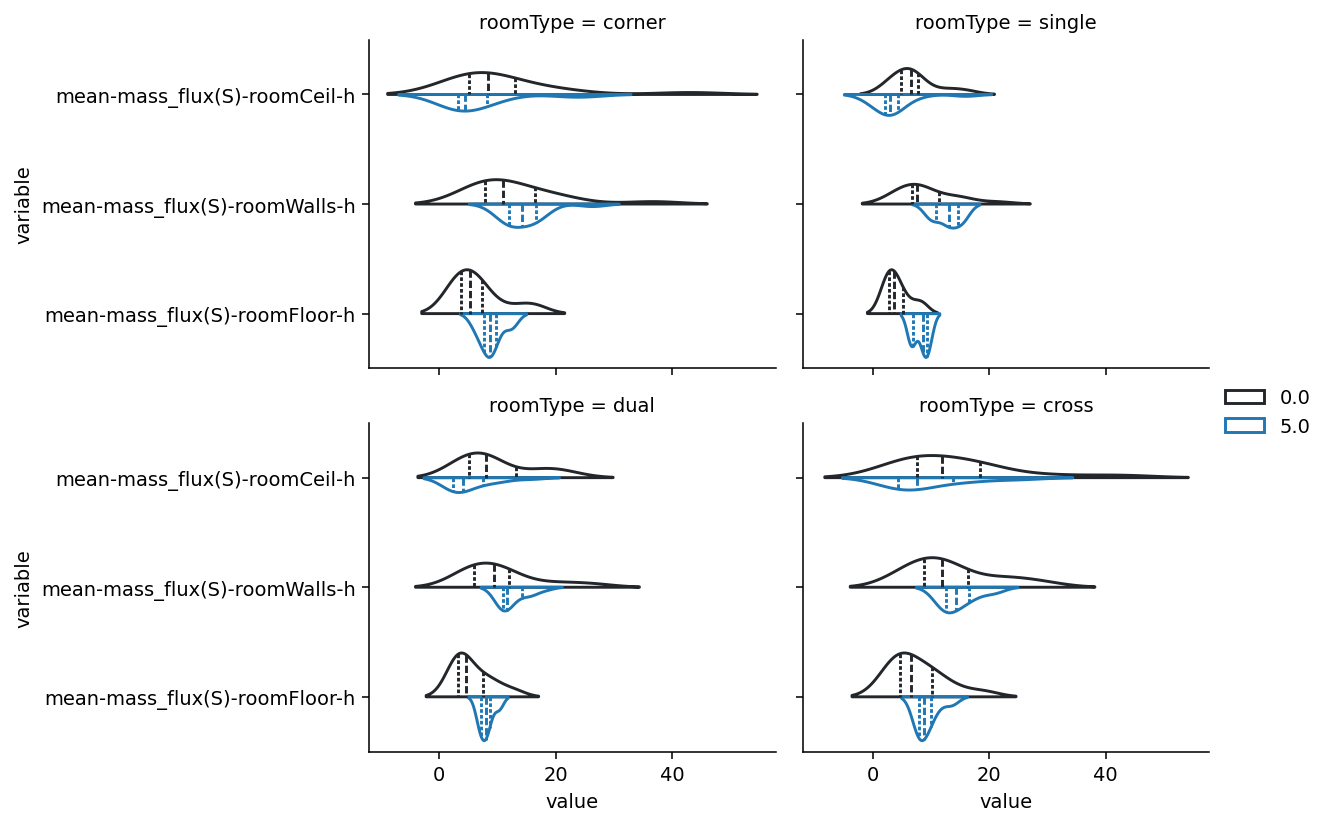

In [9]:
value_vars = ["mean-mass_flux(S)-roomCeil-Norm", "mean-mass_flux(S)-roomWalls-Norm", "mean-mass_flux(S)-roomFloor-Norm"]

plotdf = roomVentilationMI[roomVentilationMI["houseType"] == "sl"]
plotdf = plotdf[plotdf["SS"] == True]
id_vars = [ c for c in plotdf.columns.values if '-' not in c]
plotdf = pd.melt(plotdf, id_vars=id_vars, value_vars = value_vars)
plotdf["value"]

g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.5, legend_out = True)
g.map(sns.violinplot, "value", "variable", "delT", order = value_vars, hue_order = [0, 5], fill = False, inner = "quart", split = True)
g.add_legend()


value_vars = ["mean-mass_flux(S)-roomCeil-h", "mean-mass_flux(S)-roomWalls-h", "mean-mass_flux(S)-roomFloor-h"]

plotdf = roomVentilationMI[roomVentilationMI["houseType"] == "sl"]
plotdf = plotdf[plotdf["SS"] == True]
id_vars = [ c for c in plotdf.columns.values if '-' not in c]
plotdf = pd.melt(plotdf, id_vars=id_vars, value_vars = value_vars)
plotdf["value"]

g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.5, legend_out = True)
g.map(sns.violinplot, "value", "variable", "delT", order = value_vars, hue_order = [0, 5], fill = False, inner = "quart", split = True)
g.add_legend()


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `pal

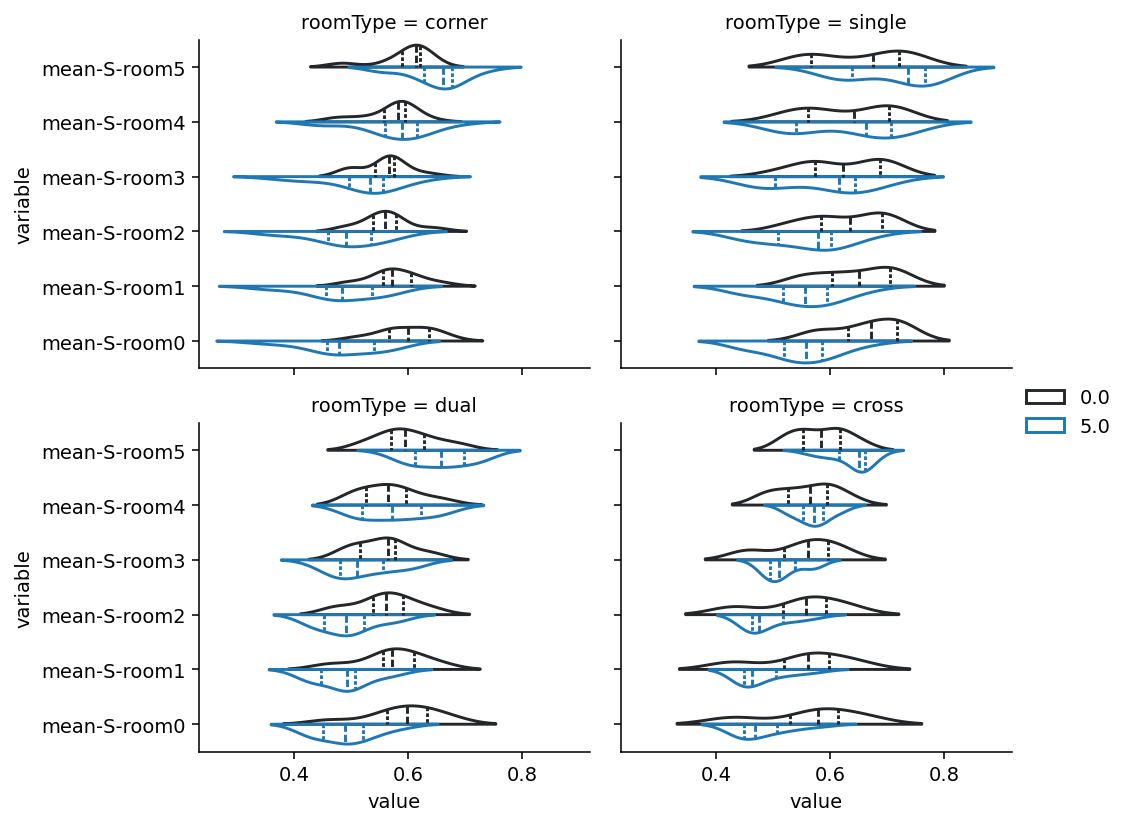

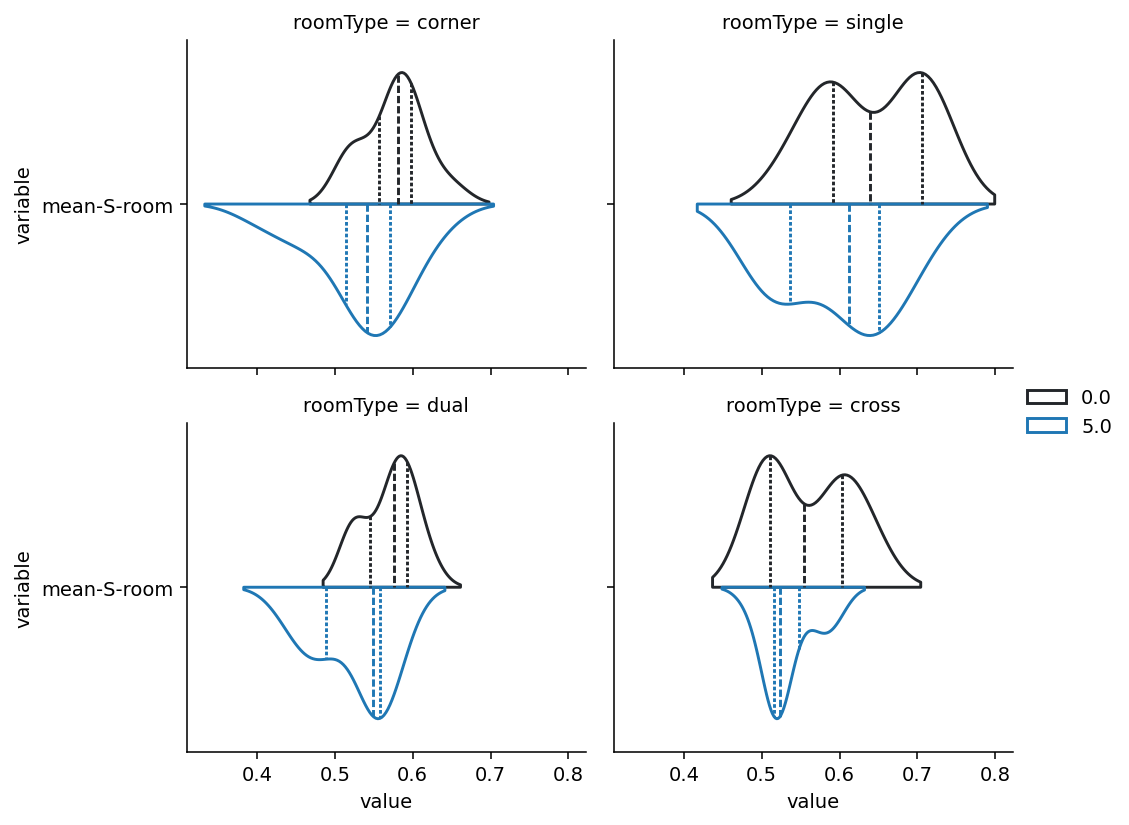

In [9]:
rooms = ["room5", "room4", "room3", "room2", "room1", "room0"]
value_vars = [f"mean-S-{r}" for r in rooms]

plotdf = roomVentilationMI[roomVentilationMI["houseType"] == "sl"]
plotdf = plotdf[plotdf["SS"] == True]
id_vars = [ c for c in plotdf.columns.values if '-' not in c]
plotdf = pd.melt(plotdf, id_vars=id_vars, value_vars = value_vars)
# plotdf["value"]

g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "value", "variable", "delT", order = value_vars, hue_order = [0, 5], fill = False, inner = "quart", split = True)
g.add_legend()

value_vars = [f"mean-S-room"]

plotdf = roomVentilationMI[roomVentilationMI["houseType"] == "sl"]
plotdf = plotdf[plotdf["SS"] == True]
id_vars = [ c for c in plotdf.columns.values if '-' not in c]
plotdf = pd.melt(plotdf, id_vars=id_vars, value_vars = value_vars)
# plotdf["value"]

g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "value", "variable", "delT", order = value_vars, hue_order = [0, 5], fill = False, inner = "quart", split = True)
g.add_legend()


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `pal

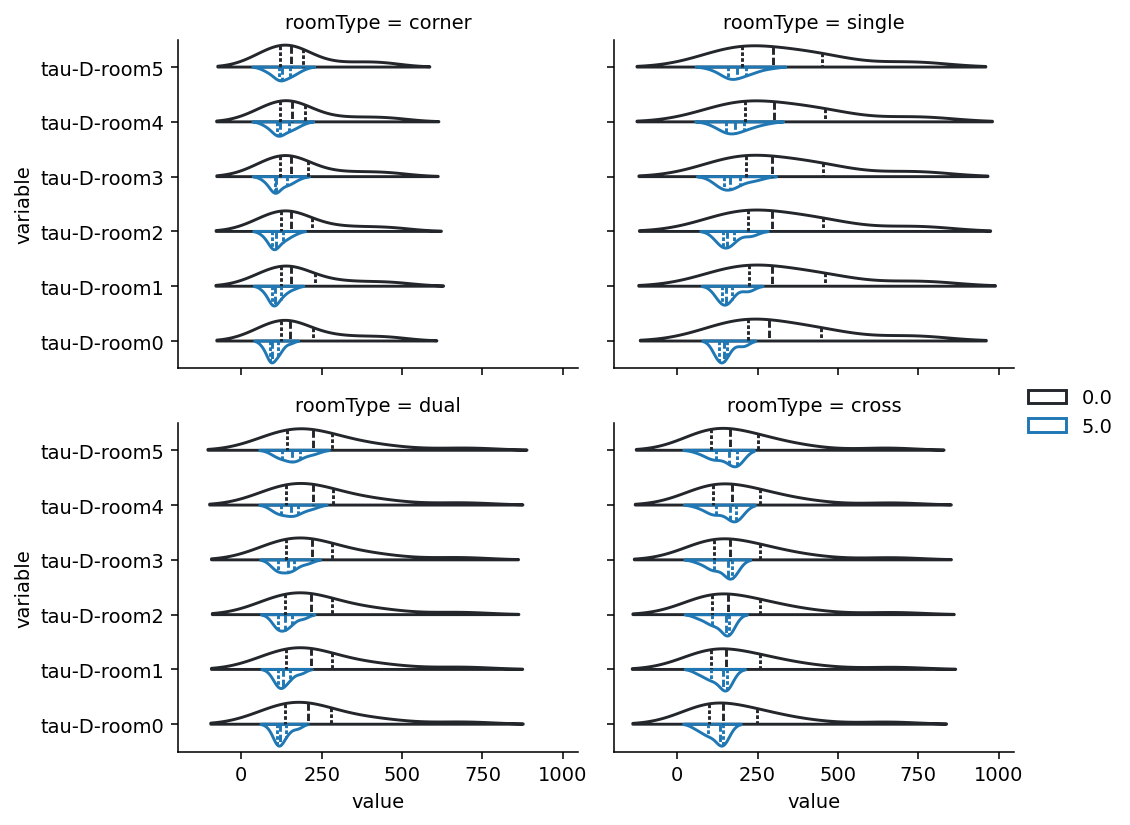

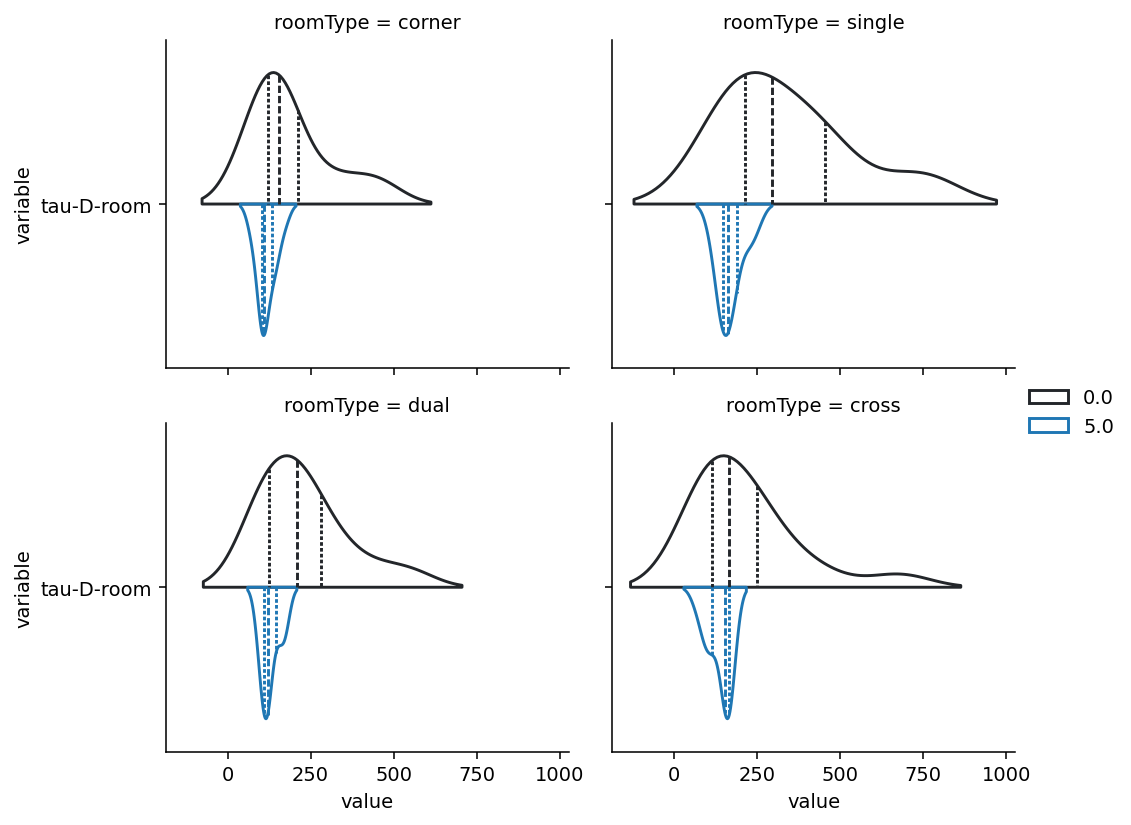

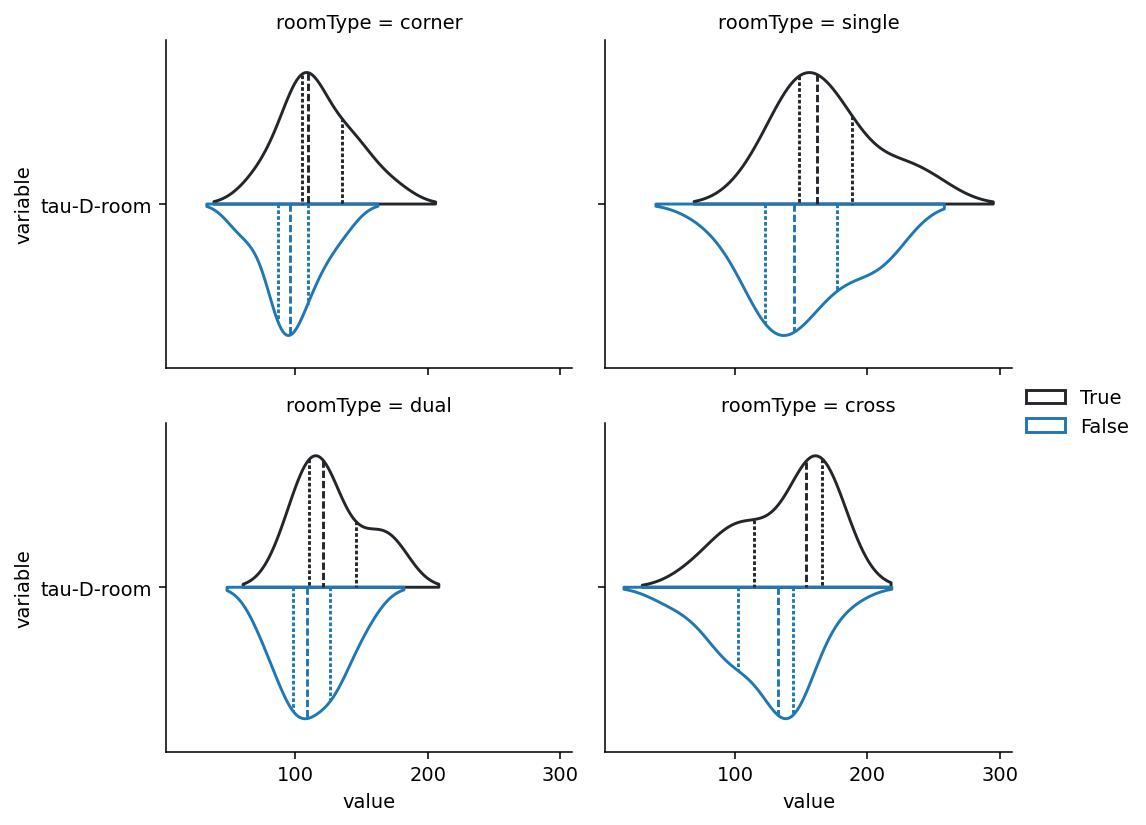

In [10]:

value_vars = [f"tau-D-{r}" for r in rooms]

plotdf = roomVentilationMI[roomVentilationMI["houseType"] == "sl"]
plotdf = plotdf[plotdf["SS"] == True]
id_vars = [ c for c in plotdf.columns.values if '-' not in c]
plotdf = pd.melt(plotdf, id_vars=id_vars, value_vars = value_vars)
plotdf["value"] = plotdf["value"].map(lambda l: l[0])
plotdf["value"]

g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "value", "variable", "delT", order = value_vars, hue_order = [0, 5], fill = False, inner = "quart", split = True)
g.add_legend()

value_vars = [f"tau-D-room"]

plotdf = roomVentilationMI[roomVentilationMI["houseType"] == "sl"]
plotdf = plotdf[plotdf["SS"] == True]
id_vars = [ c for c in plotdf.columns.values if '-' not in c]
plotdf = pd.melt(plotdf, id_vars=id_vars, value_vars = value_vars)
plotdf["value"] = plotdf["value"].map(lambda l: l[0])
plotdf["value"]

g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "value", "variable", "delT", order = value_vars, hue_order = [0, 5], fill = False, inner = "quart", split = True)
g.add_legend()

value_vars = [f"tau-D-room"]

plotdf = roomVentilationMI[roomVentilationMI["houseType"] == "sl"]
plotdf = plotdf[plotdf["delT"] == 5]
id_vars = [ c for c in plotdf.columns.values if '-' not in c]
plotdf = pd.melt(plotdf, id_vars=id_vars, value_vars = value_vars)
plotdf["value"] = plotdf["value"].map(lambda l: l[0])
plotdf["value"]

g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "value", "variable", "SS", order = value_vars, hue_order = [True, False], fill = False, inner = "quart", split = True)
g.add_legend()

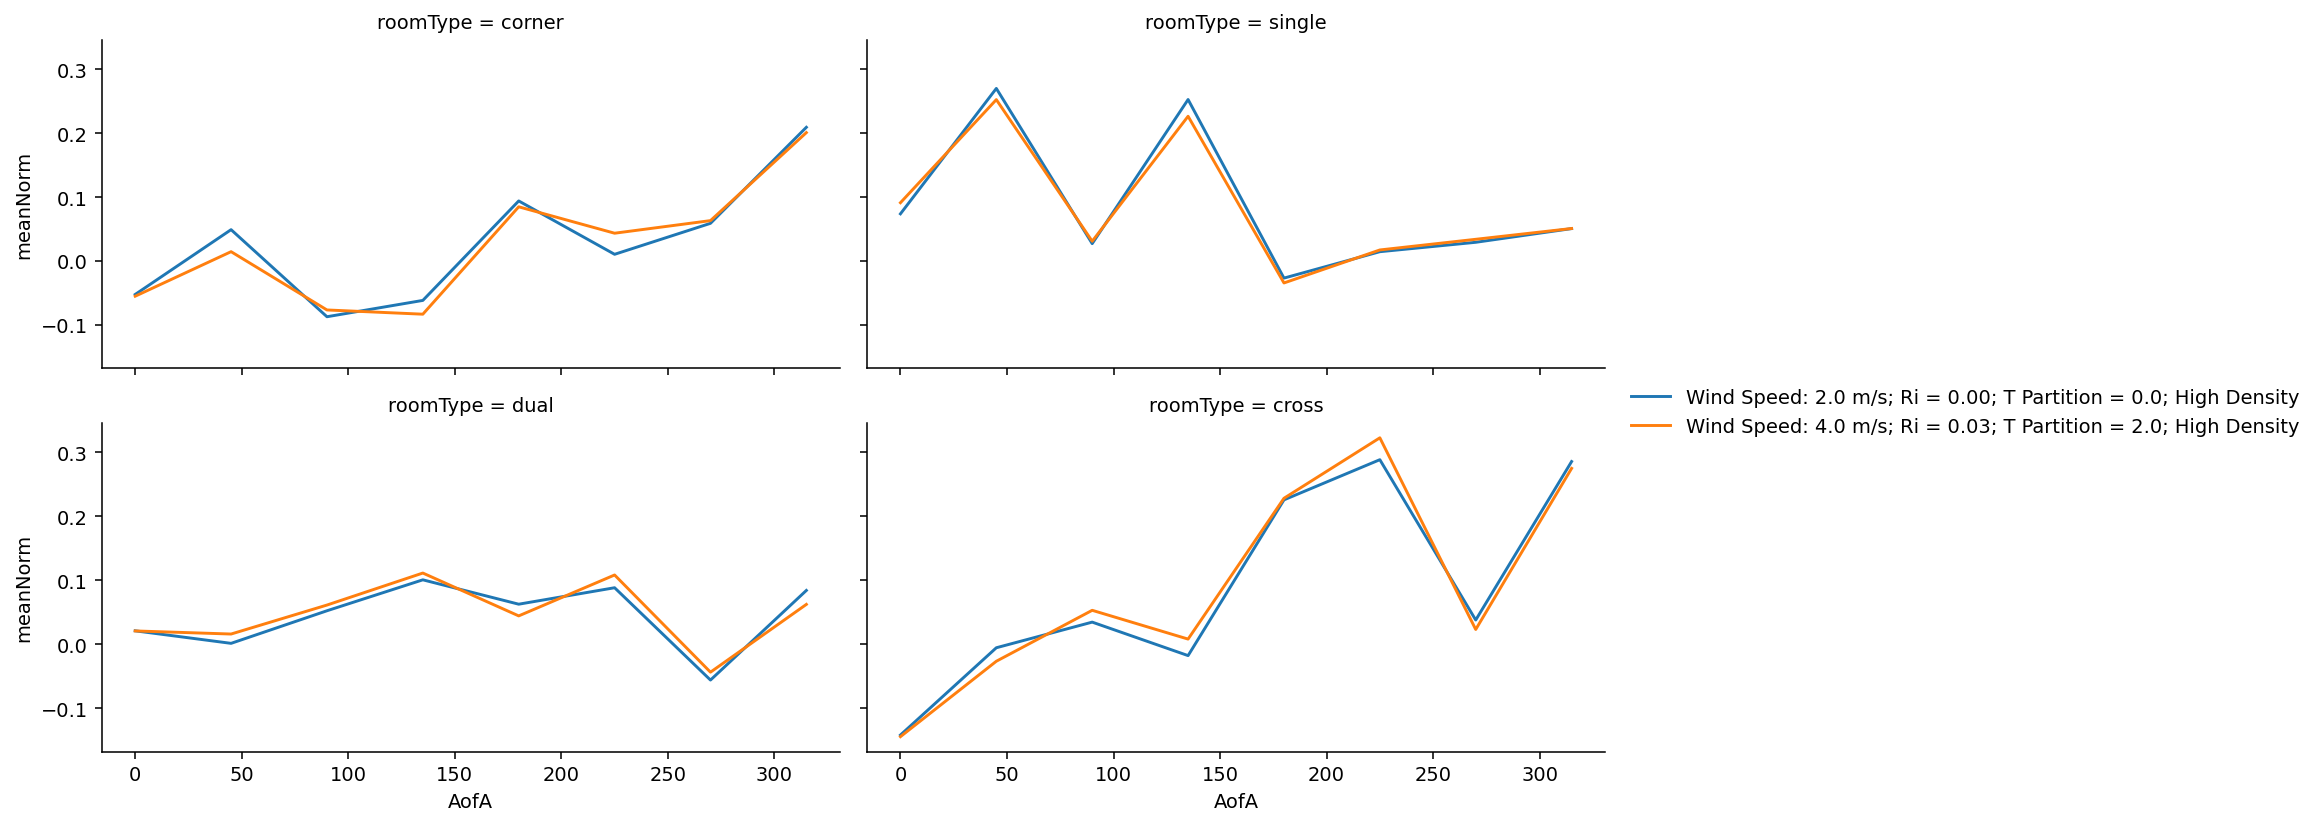

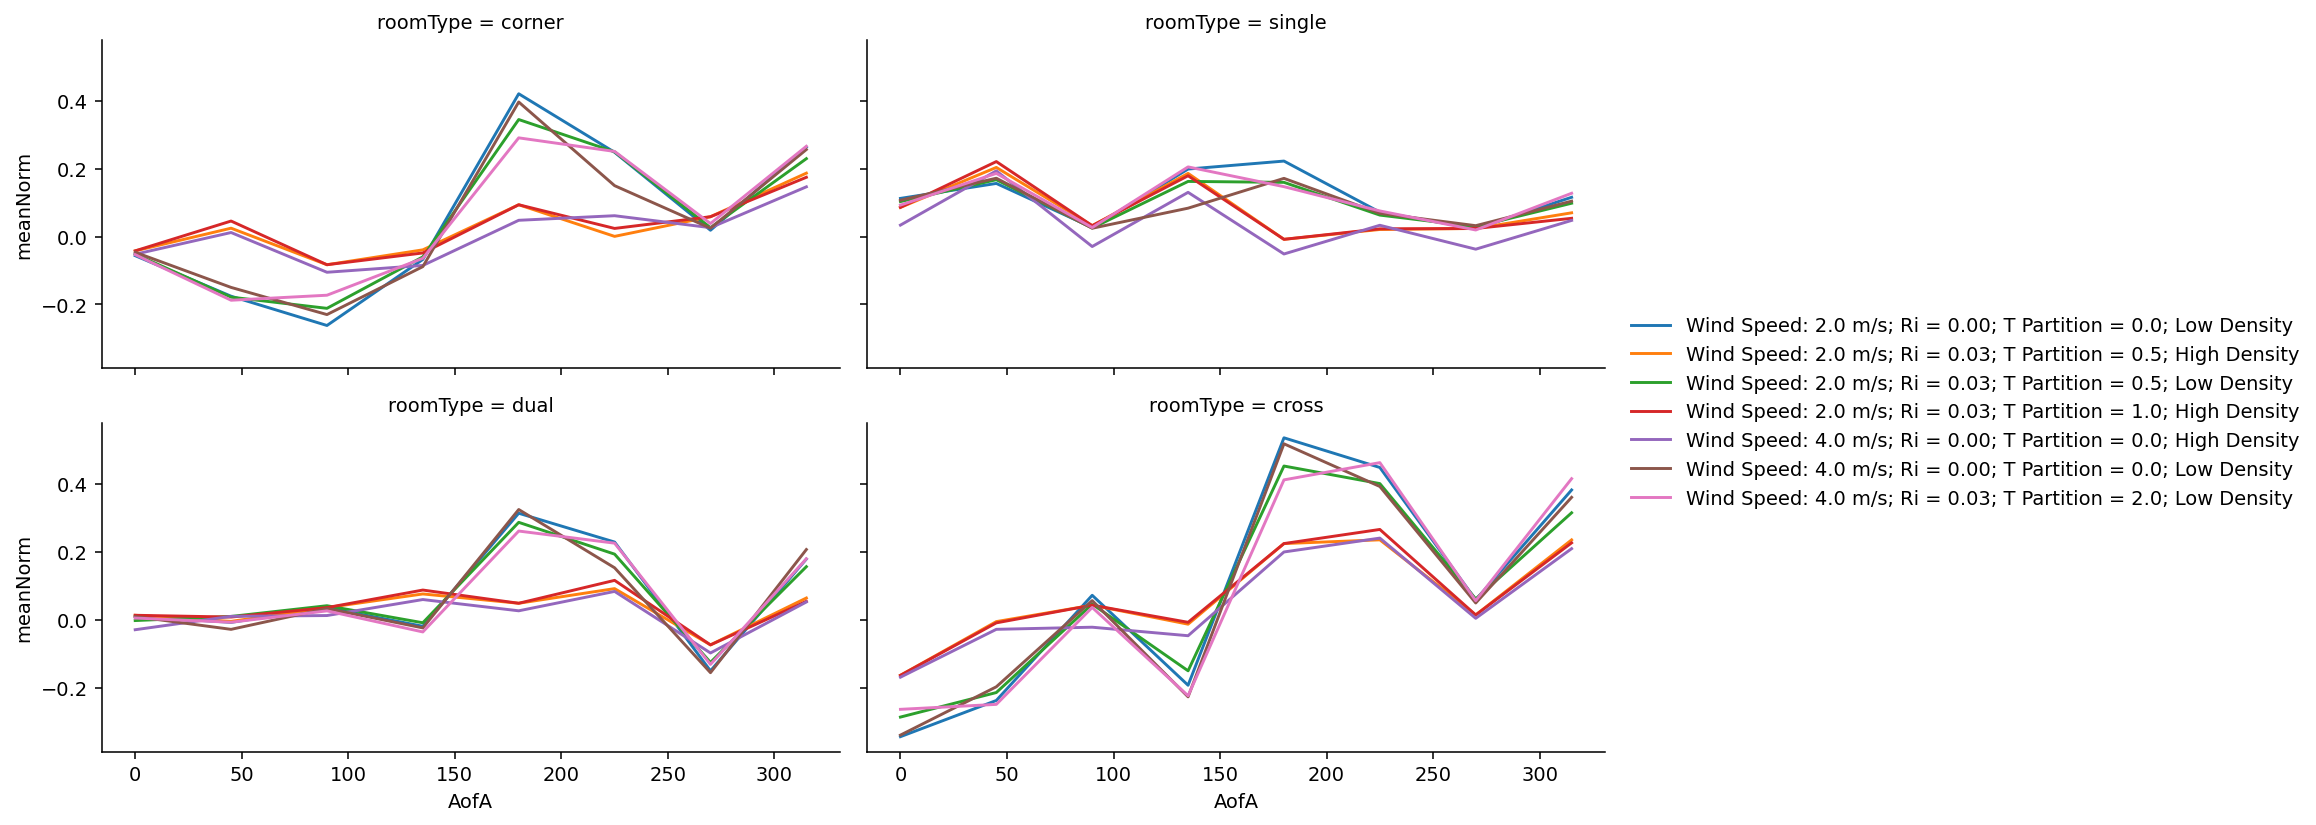

In [ ]:
paramGroup = ["Wind Speed: 2.0 m/s; Ri = 0.00; T Partition = 0.0; High Density", "Wind Speed: 4.0 m/s; Ri = 0.03; T Partition = 2.0; High Density"]

for iBool in [True, False]:
    plotdf = flowStatsMI[flowStatsMI["AofA"]%1 == 0]
    plotdf = plotdf[plotdf["houseType"] == "sl"]
    # plotdf = plotdf[plotdf["roomType"] == "corner"]
    plotdf = plotdf[plotdf["Params"].isin(paramGroup) == iBool]

    plotdfGrouped = plotdf.groupby(["roomType", "houseType", "Params", "AofA"], as_index=False).mean(numeric_only = True)
    g = sns.FacetGrid(plotdfGrouped, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 2, legend_out = True)
    # g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
    g.map(sns.lineplot, "AofA", "meanNorm", "Params", palette = "tab10")
    g.add_legend()

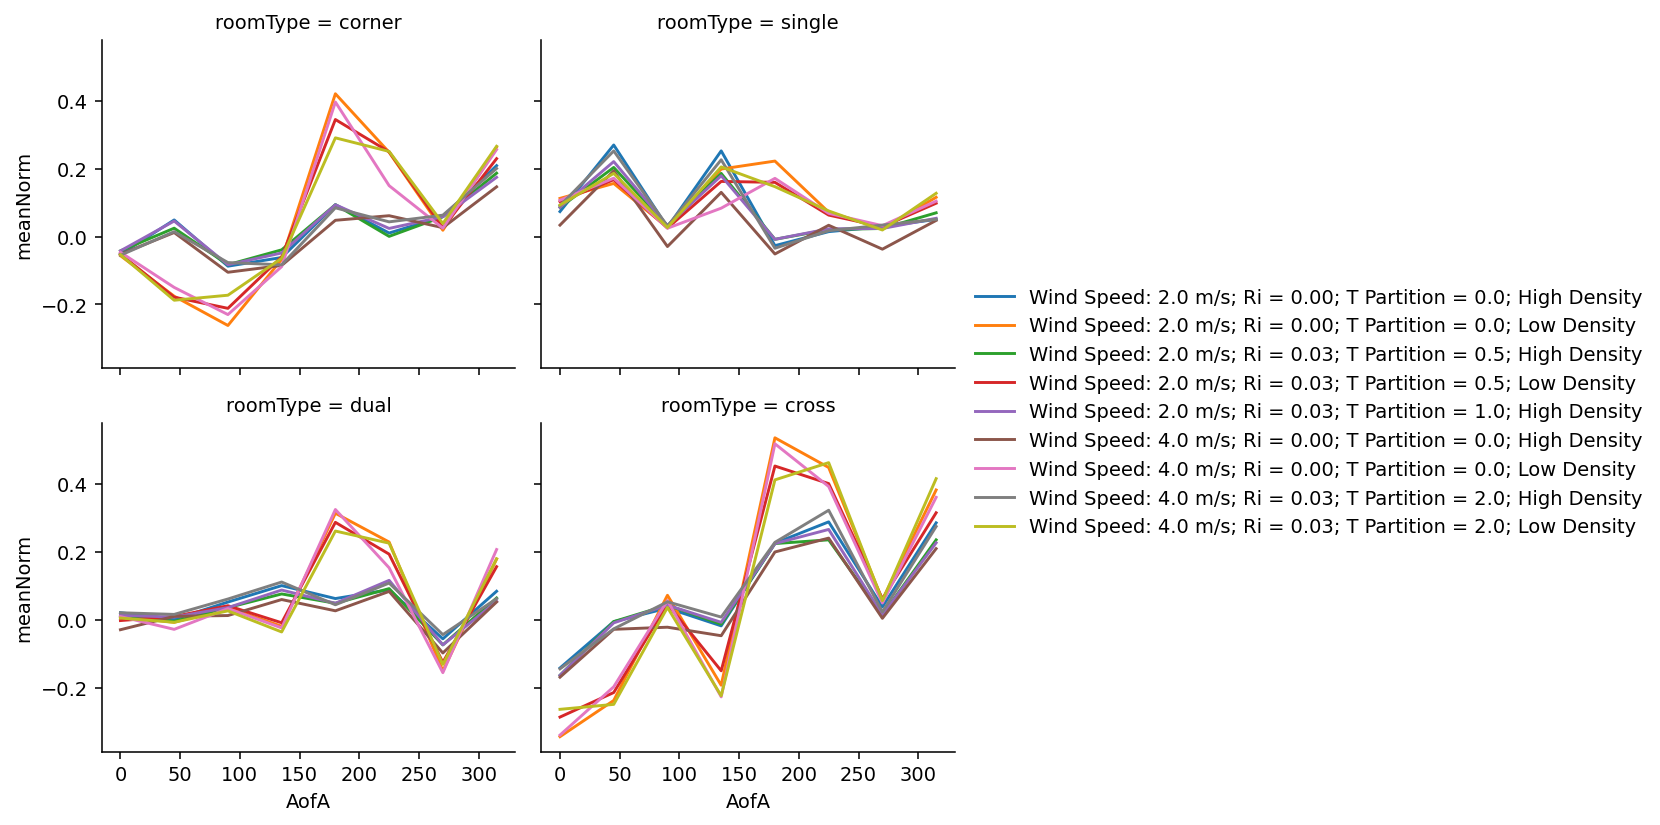

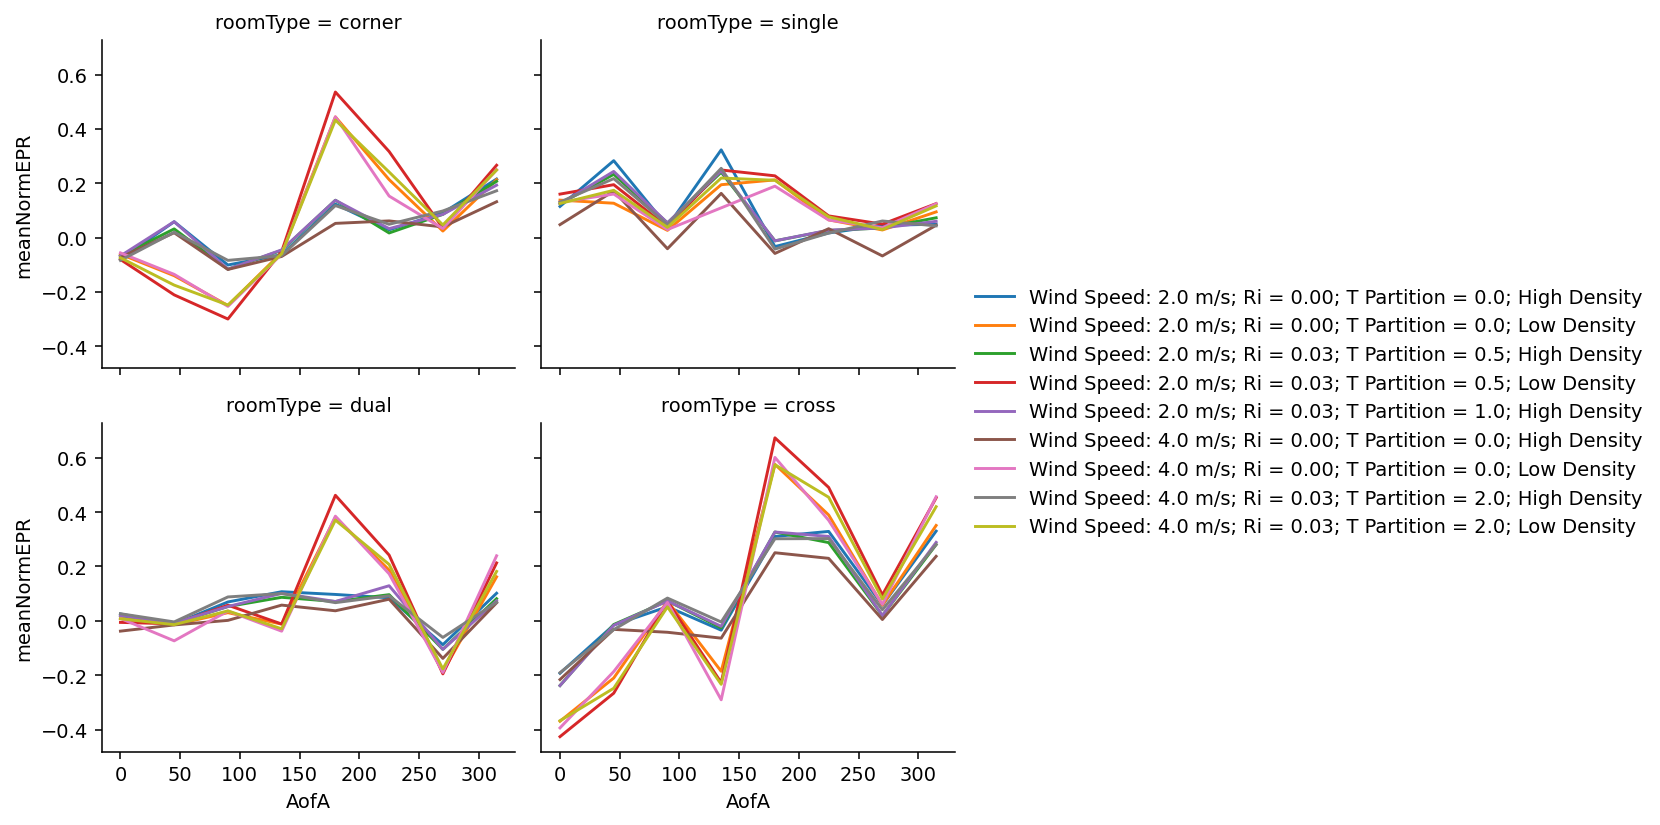

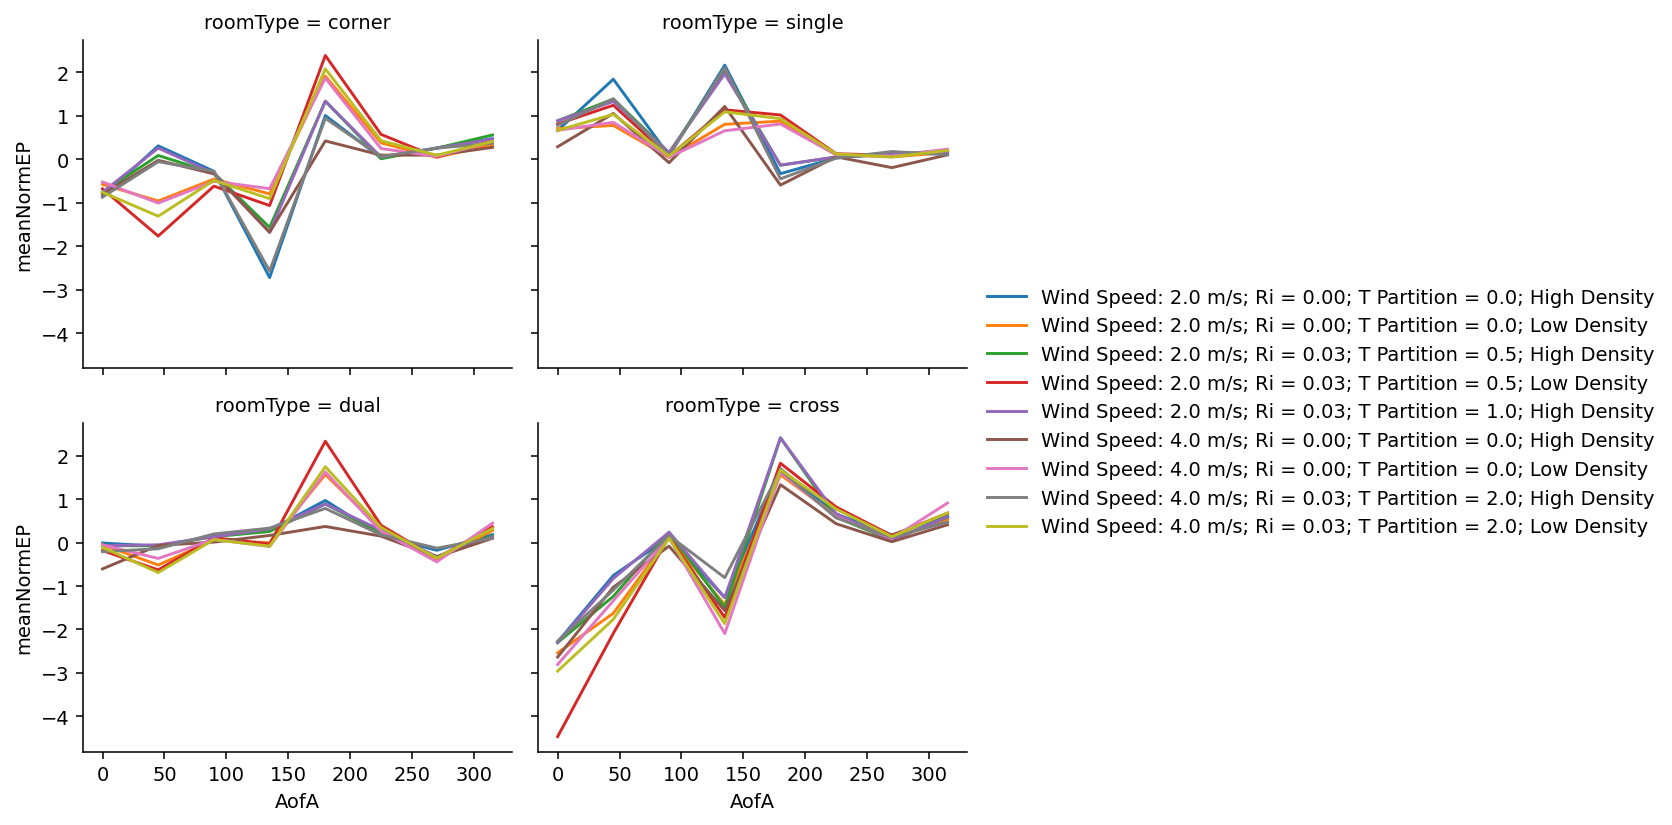

In [8]:
plotdf = flowStatsMI[flowStatsMI["AofA"]%1 == 0]
plotdf = plotdf[plotdf["houseType"] == "sl"]

plotdfGrouped = plotdf.groupby(["roomType", "houseType", "Params", "AofA"], as_index=False).mean(numeric_only = True)
g = sns.FacetGrid(plotdfGrouped, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.lineplot, "AofA", "meanNorm", "Params", palette = "tab10")
g.add_legend()

plotdfGrouped = plotdf.groupby(["roomType", "houseType", "Params", "AofA"], as_index=False).mean(numeric_only = True)
g = sns.FacetGrid(plotdfGrouped, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.lineplot, "AofA", "meanNormEPR", "Params", palette = "tab10")
g.add_legend()

plotdfGrouped = plotdf.groupby(["roomType", "houseType", "Params", "AofA"], as_index=False).mean(numeric_only = True)
g = sns.FacetGrid(plotdfGrouped, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.lineplot, "AofA", "meanNormEP", "Params", palette = "tab10")
g.add_legend()

In [9]:
plotdf = roomVentilationMI[roomVentilationMI["houseType"] == "sl"]

plotdf = plotdf.sort_values(["Params"])
fig1 = px.bar_polar(plotdf, r="netNorm", theta="AofA",
                   color="roomType", template="plotly_dark", pattern_shape = "WS",
                   color_discrete_sequence= px.colors.sequential.Viridis)
fig1.show()

fig2 = px.bar_polar(plotdf, r="netNorm", theta="AofA",
                   color="roomType", template="plotly_dark", pattern_shape = "B",
                   color_discrete_sequence= px.colors.sequential.Viridis)
fig2.show()

In [10]:
plotdf = plotdf.sort_values(["houseType", "Params"])
# plotdf = plotdf.sort_values("Params")
color_labels = ["Params"]
for i, color_label in enumerate(color_labels):
    plotdf_frac = plotdf.copy()
    fracN = plotdf_frac.shape[0] / (len(set(plotdf_frac["roomType"])) * len(set(plotdf_frac["AofA"])))
    plotdf_frac[["netNorm", "meanNorm"]] = plotdf_frac[["netNorm", "meanNorm"]] / fracN
    rooms = ["corner", "single", "dual", "cross"]
    # params = set(plotdf[color_label])
    # marker_color=px.colors.qualitative.Safe #["#E4FF87", '#709BFF', '#709BFF', '#FFAA70', '#FFAA70', '#FFDF70', '#B6FFB4']
    # color_map = {}
    # for i, param in enumerate(params):
    #     color_map[i] = marker_color[i]
    # color_map = px.colors.sequential.Viridis

    figures = []
    for i, room in enumerate(rooms):
        fig = px.bar_polar(plotdf_frac[plotdf_frac["roomType"] == room], r="netNorm", theta="AofA",
                    color=color_label, template="plotly_dark", hover_data = ["houseType"],
                    color_discrete_sequence=px.colors.qualitative.Safe, title=room)
        figures.append(fig)

    fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2, subplot_titles=rooms, vertical_spacing=0.2)

    for i, figure in enumerate(figures):
        for trace in range(len(figure["data"])):
            room = rooms[i]
            row = int((i/2)+1)
            col = int((i%2)+1)
            # print(row, col)
            trace = figure["data"][trace]
            if i>0:
                trace.showlegend = False
            fig.add_trace(trace, row=row, col=col)
            fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

    # fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.5])
    fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.7])
    fig.update_layout(width = 1000, height = 800)


    fig.show()
    fig.write_image(f'{plotFolder}radialByParams.png', scale=2)
    
    # print(fig)

In [11]:
plotdf = plotdf.sort_values(["houseType", "Params"])
# plotdf = plotdf.sort_values("Params")
color_labels = ["Params"]
for i, color_label in enumerate(color_labels):
    plotdf_frac = plotdf.copy()
    fracN = plotdf_frac.shape[0] / (len(set(plotdf_frac["roomType"])) * len(set(plotdf_frac["AofA"])))
    plotdf_frac[["netNorm", "meanNorm", "netNormEPR", "meanNormEPR"]] = plotdf_frac[["netNorm", "meanNorm", "netNormEPR", "meanNormEPR"]] / fracN
    rooms = ["corner", "single", "dual", "cross"]
    # params = set(plotdf[color_label])
    # marker_color=px.colors.qualitative.Safe #["#E4FF87", '#709BFF', '#709BFF', '#FFAA70', '#FFAA70', '#FFDF70', '#B6FFB4']
    # color_map = {}
    # for i, param in enumerate(params):
    #     color_map[i] = marker_color[i]
    # color_map = px.colors.sequential.Viridis

    figures = []
    for i, room in enumerate(rooms):
        plotdf_frac_room = plotdf_frac[plotdf_frac["roomType"] == room]
        fig = px.bar_polar(plotdf_frac_room, r="netNormEPR", theta="AofA",
                    color=color_label, template="plotly_dark", hover_data = ["houseType"],
                    color_discrete_sequence=px.colors.qualitative.Safe, title=room)
        figures.append(fig)

    fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2, subplot_titles=rooms, vertical_spacing=0.2)

    for i, figure in enumerate(figures):
        for trace in range(len(figure["data"])):
            room = rooms[i]
            row = int((i/2)+1)
            col = int((i%2)+1)
            # print(row, col)
            trace = figure["data"][trace]
            if i>0:
                trace.showlegend = False
            fig.add_trace(trace, row=row, col=col)
            fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

    # fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.5])
    fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.75])
    fig.update_layout(width = 1000, height = 800)


    fig.show()
    fig.write_image(f'{plotFolder}radialByParamsEPR.png', scale=2)
    
    # print(fig)

In [12]:
plotdf = roomVentilationMI[roomVentilationMI["houseType"].isin(["sl", "3-2"])]

dfCompHT, valuesHT = getComparativeDf(plotdf, ["houseType"])
dfCompHT["netNorm"]

fig = px.scatter(x = dfCompHT[('netNorm', *valuesHT[0])], y = dfCompHT[('netNorm', *valuesHT[1])], symbol = indMulti(dfCompHT.index, ['roomType']), color = indMulti(dfCompHT.index, ['roomType']), hover_data = indMulti(dfCompHT.index, ['AofA', 'WS']))

fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=np.max(dfCompHT["netNorm"]), 
              y1=np.max(dfCompHT["netNorm"]))

fig.update_layout(
    # xaxis_title=r'$\text{Normalized Ventilation Rate} V_{10) = 2 m/s$',
    xaxis_title=r'$\text{No Skylights; Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
    yaxis_title=r'$\text{Skylights; Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
    # legend_title=r'Room Type',
)
fig.show()
fig.write_image(f'{plotFolder}scatterHT_2-4.png', scale=2)

split ['houseType'] along values:  [('3-2',), ('sl',)]


In [13]:

categorizeBy = ["C", "roomType"]
categoryValues = [plotdf[category].unique() for category in categorizeBy]
splitAlong = ["houseType"]
splitInd = [0, 1]
figures = []
for i, v0 in enumerate(categoryValues[0]):
    for j, v1 in enumerate(categoryValues[1]):
        plotdfSplit = plotdf[((plotdf[categorizeBy[0]] == v0) & (plotdf[categorizeBy[1]] == v1))]
        dfComp, values = getComparativeDf(plotdfSplit, splitAlong)
        color = indMulti(dfComp.index, ['Ri'])
        fig = px.scatter(x = dfComp['netNorm'].iloc[:,splitInd[0]], y = dfComp['netNorm'].iloc[:,splitInd[1]], 
            color = color, symbol = indMulti(dfComp.index, ['Ri']),  hover_data = indMulti(dfComp.index, ['C', 'roomType', 'AofA', 'delTPartRatio']))
        figures.append(fig)

num_rows = len(categoryValues[0])
num_cols = len(categoryValues[1])

titleText = []
for CValue in categoryValues[1]:
    text = f"{categorizeBy[1]} = "
    if isinstance(CValue, float):
        text = f"{text}{np.round(CValue, 2)}"
    else:
        text = f"{text}{CValue}"
    titleText.append(text)

fig = make_subplots(rows=num_rows, cols=num_cols, vertical_spacing=0.2)#, subplot_titles=titleText)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        row = int(i / num_cols) + 1  # Calculate row index
        col = (i % num_cols) + 1  # Calculate column index
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        # fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

# fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
# fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
fig.update_layout(width = 1000, height = 800, title_text = f"{splitAlong[0]} {values[splitInd[0]][0]} vs {values[splitInd[1]][0]}")
fig.update_coloraxes(colorscale = "mrybm", colorbar_orientation = "h", colorbar_y = -0.2, cmin = 0, cmax = 360)

fig.add_shape(type="line",
    x0=0, 
    y0=0, 
    x1=np.max(plotdf["netNorm"]) * 1.2, 
    y1=np.max(plotdf["netNorm"]) * 1.2,
    col = "all",
    row = "all")

# Update x-axis and y-axis properties for each subplot
for i, v0 in enumerate(categoryValues[0]):
    yLabelText = f"{categorizeBy[0]} = {v0}"
    fig.update_yaxes(title_text=yLabelText, row=i+1, col=1)  # Add y-axis label

for j, v1 in enumerate(categoryValues[1]):
    xLabelText = f"{categorizeBy[1]} = {v1}"
    fig.update_xaxes(title_text=xLabelText, row=num_rows, col=j+1)  # Add x-axis label

fig.show()

split ['houseType'] along values:  [('3-2',), ('sl',)]
split ['houseType'] along values:  [('3-2',), ('sl',)]
split ['houseType'] along values:  [('3-2',), ('sl',)]
split ['houseType'] along values:  [('3-2',), ('sl',)]
split ['houseType'] along values:  [('3-2',), ('sl',)]
split ['houseType'] along values:  [('3-2',), ('sl',)]
split ['houseType'] along values:  [('3-2',), ('sl',)]
split ['houseType'] along values:  [('3-2',), ('sl',)]


In [14]:
plotdf = roomVentilationMI[roomVentilationMI["houseType"] == "sl"]
for CValue in [2,3]:
    dfCompWS, valuesWS = getComparativeDf(plotdf[plotdf["C"] == CValue], ["WS"])
    fig = px.scatter(x = dfCompWS[('netNorm', *valuesWS[0])], y = dfCompWS[('netNorm', *valuesWS[1])], symbol = indMulti(dfCompWS.index, ['C']), color = indMulti(dfCompWS.index, ['Ri']), hover_data = indMulti(dfCompWS.index, ['Ri', 'AofA', 'C']))

    fig.add_shape(type="line",
                x0=0, 
                y0=0, 
                x1=np.max(dfCompWS["netNorm"]), 
                y1=np.max(dfCompWS["netNorm"]))

    fig.update_layout(
        # xaxis_title=r'$\text{Normalized Ventilation Rate} V_{10) = 2 m/s$',
        xaxis_title=r'$U_{10} = 2 m/s, \text{Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
        yaxis_title=r'$U_{10} = 4 m/s, \text{Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
        # legend_title=r'Room Type',
    )
    fig.show()
    fig.write_image(f'{plotFolder}scatterWS_2-4.png', scale=2)


    # fig = px.scatter(x = dfCompWS[('netNorm', *valuesWS[1])], y = dfCompWS[('netNorm', *valuesWS[2])], symbol = indMulti(dfCompWS.index, ['roomType']), color = indMulti(dfCompWS.index, ['Ri']), hover_data = indMulti(dfCompWS.index, ['Ri, 'AofA']))

    # fig.add_shape(type="line",
    #               x0=0, 
    #               y0=0, 
    #               x1=np.max(dfCompWS["netNorm"]), 
    #               y1=np.max(dfCompWS["netNorm"]))

    # fig.update_layout(
    #     # xaxis_title=r'$\text{Normalized Ventilation Rate} V_{10) = 2 m/s$',
    #     xaxis_title=r'$U_{10} = 4 m/s, \text{Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
    #     yaxis_title=r'$U_{10} = 6 m/s, \text{Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
    #     # legend_title=r'Room Type',
    # )
    # fig.show()
    # fig.write_image(f'{plotFolder}scatterWS_4-6.png', scale=2)

split ['WS'] along values:  [(4.0,), (2.0,)]


split ['WS'] along values:  [(4.0,), (2.0,)]


In [15]:

categorizeBy = ["C", "roomType"]
categoryValues = [plotdf[category].unique() for category in categorizeBy]
splitAlong = ["WS"]
splitInd = [0, 1]
figures = []
for i, v0 in enumerate(categoryValues[0]):
    for j, v1 in enumerate(categoryValues[1]):
        plotdfSplit = plotdf[((plotdf[categorizeBy[0]] == v0) & (plotdf[categorizeBy[1]] == v1))]
        dfComp, values = getComparativeDf(plotdfSplit, splitAlong)
        color = indMulti(dfComp.index, ['Ri'])
        fig = px.scatter(x = dfComp['netNorm'].iloc[:,splitInd[0]], y = dfComp['netNorm'].iloc[:,splitInd[1]], 
            color = color, symbol = indMulti(dfComp.index, ['Ri']),  hover_data = indMulti(dfComp.index, ['C', 'roomType', 'AofA', 'delTPartRatio']))
        figures.append(fig)

num_rows = len(categoryValues[0])
num_cols = len(categoryValues[1])

titleText = []
for CValue in categoryValues[1]:
    text = f"{categorizeBy[1]} = "
    if isinstance(CValue, float):
        text = f"{text}{np.round(CValue, 2)}"
    else:
        text = f"{text}{CValue}"
    titleText.append(text)

fig = make_subplots(rows=num_rows, cols=num_cols, vertical_spacing=0.2)#, subplot_titles=titleText)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        row = int(i / num_cols) + 1  # Calculate row index
        col = (i % num_cols) + 1  # Calculate column index
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        # fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

# fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
# fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
fig.update_layout(width = 1000, height = 800, title_text = f"{splitAlong[0]} {values[splitInd[0]][0]} vs {values[splitInd[1]][0]}")
fig.update_coloraxes(colorscale = "mrybm", colorbar_orientation = "h", colorbar_y = -0.2, cmin = 0, cmax = 360)

fig.add_shape(type="line",
    x0=0, 
    y0=0, 
    x1=np.max(plotdf["netNorm"]) * 1.2, 
    y1=np.max(plotdf["netNorm"]) * 1.2,
    col = "all",
    row = "all")

# Update x-axis and y-axis properties for each subplot
for i, v0 in enumerate(categoryValues[0]):
    yLabelText = f"{categorizeBy[0]} = {v0}"
    fig.update_yaxes(title_text=yLabelText, row=i+1, col=1)  # Add y-axis label

for j, v1 in enumerate(categoryValues[1]):
    xLabelText = f"{categorizeBy[1]} = {v1}"
    fig.update_xaxes(title_text=xLabelText, row=num_rows, col=j+1)  # Add x-axis label

fig.show()

split ['WS'] along values:  [(4.0,), (2.0,)]
split ['WS'] along values:  [(4.0,), (2.0,)]
split ['WS'] along values:  [(4.0,), (2.0,)]
split ['WS'] along values:  [(4.0,), (2.0,)]
split ['WS'] along values:  [(4.0,), (2.0,)]
split ['WS'] along values:  [(4.0,), (2.0,)]
split ['WS'] along values:  [(4.0,), (2.0,)]
split ['WS'] along values:  [(4.0,), (2.0,)]


In [16]:
plotdf = plotdf.sort_values(["Params", "houseType"])

categorizeBy = ["C", "roomType"]
categoryValues = [plotdf[category].unique() for category in categorizeBy]
splitAlong = ["WS"]
splitInd = [0, 1]
figures = []
for i, v0 in enumerate(categoryValues[0]):
    for j, v1 in enumerate(categoryValues[1]):
        plotdfSplit = plotdf[((plotdf[categorizeBy[0]] == v0) & (plotdf[categorizeBy[1]] == v1))]
        dfComp, values = getComparativeDf(plotdfSplit, splitAlong)
        color = indMulti(dfComp.index, ['AofA']).astype(float)
        fig = px.scatter(x = dfComp['netNorm'].iloc[:,splitInd[0]], y = dfComp['netNorm'].iloc[:,splitInd[1]], 
            color = color, symbol = indMulti(dfComp.index, ['Ri']),  hover_data = indMulti(dfComp.index, ['C', 'roomType', 'AofA', 'delTPartRatio']))
        figures.append(fig)

num_rows = len(categoryValues[0])
num_cols = len(categoryValues[1])

titleText = []
for CValue in categoryValues[1]:
    text = f"{categorizeBy[1]} = "
    if isinstance(CValue, float):
        text = f"{text}{np.round(CValue, 2)}"
    else:
        text = f"{text}{CValue}"
    titleText.append(text)

fig = make_subplots(rows=num_rows, cols=num_cols, vertical_spacing=0.2)#, subplot_titles=titleText)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        row = int(i / num_cols) + 1  # Calculate row index
        col = (i % num_cols) + 1  # Calculate column index
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        # fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

# fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
# fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
fig.update_layout(width = 1000, height = 800, title_text = f"{splitAlong[0]} {values[splitInd[0]][0]} vs {values[splitInd[1]][0]}")
fig.update_coloraxes(colorscale = "mrybm", colorbar_orientation = "h", colorbar_y = -0.2, cmin = 0, cmax = 360)

fig.add_shape(type="line",
    x0=0, 
    y0=0, 
    x1=np.max(plotdf["netNorm"]) * 1.2, 
    y1=np.max(plotdf["netNorm"]) * 1.2,
    col = "all",
    row = "all")

# Update x-axis and y-axis properties for each subplot
for i, v0 in enumerate(categoryValues[0]):
    yLabelText = f"{categorizeBy[0]} = {v0}"
    fig.update_yaxes(title_text=yLabelText, row=i+1, col=1)  # Add y-axis label

for j, v1 in enumerate(categoryValues[1]):
    xLabelText = f"{categorizeBy[1]} = {v1}"
    fig.update_xaxes(title_text=xLabelText, row=num_rows, col=j+1)  # Add x-axis label

fig.show()

split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]


In [17]:
plotdf = plotdf.sort_values(["Params", "houseType"])

categorizeBy = ["C", "roomType"]
categoryValues = [plotdf[category].unique() for category in categorizeBy]
splitAlong = ["WS"]
splitInd = [0, 1]
figures = []
for i, v0 in enumerate(categoryValues[0]):
    for j, v1 in enumerate(categoryValues[1]):
        plotdfSplit = plotdf[((plotdf[categorizeBy[0]] == v0) & (plotdf[categorizeBy[1]] == v1))]
        dfComp, values = getComparativeDf(plotdfSplit, splitAlong)
        # color = indMulti(dfComp.index, ['AofA']).astype(float)
        color = indMulti(dfComp.index, ['Ri'])
        fig = px.scatter(x = dfComp['EP_normal_mag'].iloc[:,splitInd[0]] / values[0], y = dfComp['EP_normal_mag'].iloc[:,splitInd[1]] / values[1], 
            color = color, symbol = indMulti(dfComp.index, ['Ri']),  hover_data = indMulti(dfComp.index, ['C', 'roomType', 'AofA', 'delTPartRatio']))
        figures.append(fig)

num_rows = len(categoryValues[0])
num_cols = len(categoryValues[1])

titleText = []
for CValue in categoryValues[1]:
    text = f"{categorizeBy[1]} = "
    if isinstance(CValue, float):
        text = f"{text}{np.round(CValue, 2)}"
    else:
        text = f"{text}{CValue}"
    titleText.append(text)

fig = make_subplots(rows=num_rows, cols=num_cols, vertical_spacing=0.2)#, subplot_titles=titleText)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        row = int(i / num_cols) + 1  # Calculate row index
        col = (i % num_cols) + 1  # Calculate column index
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        # fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

# fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
# fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
fig.update_layout(width = 1000, height = 800, title_text = f"{splitAlong[0]} {values[splitInd[0]][0]} vs {values[splitInd[1]][0]}")
fig.update_coloraxes(colorscale = "mrybm", colorbar_orientation = "h", colorbar_y = -0.2, cmin = 0, cmax = 360)

fig.add_shape(type="line",
    x0=0, 
    y0=0, 
    x1=np.max(plotdf["EP_normal_mag"]) / 4 * 1.2, 
    y1=np.max(plotdf["EP_normal_mag"]) / 4 * 1.2,
    col = "all",
    row = "all")

# Update x-axis and y-axis properties for each subplot
for i, v0 in enumerate(categoryValues[0]):
    yLabelText = f"{categorizeBy[0]} = {v0}"
    fig.update_yaxes(title_text=yLabelText, row=i+1, col=1)  # Add y-axis label

for j, v1 in enumerate(categoryValues[1]):
    xLabelText = f"{categorizeBy[1]} = {v1}"
    fig.update_xaxes(title_text=xLabelText, row=num_rows, col=j+1)  # Add x-axis label

fig.show()

split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]


In [18]:
plotdf = plotdf.sort_values(["Params", "houseType"])

categorizeBy = ["C", "roomType"]
categoryValues = [plotdf[category].unique() for category in categorizeBy]
splitAlong = ["WS"]
splitInd = [0, 1]
figures = []
for i, v0 in enumerate(categoryValues[0]):
    for j, v1 in enumerate(categoryValues[1]):
        plotdfSplit = plotdf[((plotdf[categorizeBy[0]] == v0) & (plotdf[categorizeBy[1]] == v1))]
        dfComp, values = getComparativeDf(plotdfSplit, splitAlong)
        # color = indMulti(dfComp.index, ['AofA']).astype(float)
        color = indMulti(dfComp.index, ['Ri'])
        fig = px.scatter(x = dfComp['EP_shear'].iloc[:,splitInd[0]] / values[0], y = dfComp['EP_shear'].iloc[:,splitInd[1]] / values[1], 
            color = color, symbol = indMulti(dfComp.index, ['Ri']),  hover_data = indMulti(dfComp.index, ['C', 'roomType', 'AofA', 'delTPartRatio']))
        figures.append(fig)

num_rows = len(categoryValues[0])
num_cols = len(categoryValues[1])

titleText = []
for CValue in categoryValues[1]:
    text = f"{categorizeBy[1]} = "
    if isinstance(CValue, float):
        text = f"{text}{np.round(CValue, 2)}"
    else:
        text = f"{text}{CValue}"
    titleText.append(text)

fig = make_subplots(rows=num_rows, cols=num_cols, vertical_spacing=0.2)#, subplot_titles=titleText)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        row = int(i / num_cols) + 1  # Calculate row index
        col = (i % num_cols) + 1  # Calculate column index
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        # fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

# fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
# fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
fig.update_layout(width = 1000, height = 800, title_text = f"{splitAlong[0]} {values[splitInd[0]][0]} vs {values[splitInd[1]][0]}")
fig.update_coloraxes(colorscale = "mrybm", colorbar_orientation = "h", colorbar_y = -0.2, cmin = 0, cmax = 360)

fig.add_shape(type="line",
    x0=0, 
    y0=0, 
    x1=np.max(plotdf["EP_shear"]) / 4 * 1.2, 
    y1=np.max(plotdf["EP_shear"]) / 4 * 1.2,
    col = "all",
    row = "all")

# Update x-axis and y-axis properties for each subplot
for i, v0 in enumerate(categoryValues[0]):
    yLabelText = f"{categorizeBy[0]} = {v0}"
    fig.update_yaxes(title_text=yLabelText, row=i+1, col=1)  # Add y-axis label

for j, v1 in enumerate(categoryValues[1]):
    xLabelText = f"{categorizeBy[1]} = {v1}"
    fig.update_xaxes(title_text=xLabelText, row=num_rows, col=j+1)  # Add x-axis label

fig.show()

split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]


In [19]:
plotdf = plotdf.sort_values(["Params", "houseType"])

splitAlong = ["Ri", "delTPartRatio"]
dfComp, values = getComparativeDf(plotdf, splitAlong)
figures = []
baseInd = 0
for i, v in enumerate(values):
    if i == baseInd:
        continue
    fig = px.scatter(x = dfComp['netNorm'].iloc[:,baseInd], y = dfComp['netNorm'].iloc[:,i], color = indMulti(dfComp.index, ['WS']), hover_data = indMulti(dfComp.index, ['WS', 'AofA']))
    figures.append(fig)

num_rows = 1
num_cols = int(np.ceil((len(values) - 1) / num_rows))

fig = make_subplots(rows=num_rows, cols=num_cols, vertical_spacing=0.2)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        row = int(i / num_cols) + 1  # Calculate row index
        col = (i % num_cols) + 1  # Calculate column index
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        # fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

# fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
# fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
fig.update_layout(width = 1000, height = 800)

fig.add_shape(type="line",
    x0=0, 
    y0=0, 
    x1=np.max(dfComp["netNorm"]) * 1.2, 
    y1=np.max(dfComp["netNorm"]) * 1.2,
    col = "all",
    row = "all")

# Update x-axis and y-axis properties for each subplot
labelText = []
for v in values:
    text = ""
    for i, split in enumerate(splitAlong):
        text = f"{text}{split} = {np.round(v[i], 2)};  "
    text = text[:-3]
    labelText.append(text)
for i, text in enumerate(labelText):
    if i == baseInd:
        continue
    fig.update_xaxes(title_text=labelText[0], row=1, col=i)  # Add x-axis label
    fig.update_yaxes(title_text=text, row=1, col=i)  # Add y-axis label

fig.show()

KeyError occurred: 0.5; Likely a non-issue due to not having all possible split combinations in data
KeyError occurred: 1.0; Likely a non-issue due to not having all possible split combinations in data
KeyError occurred: 0.0; Likely a non-issue due to not having all possible split combinations in data
split ['Ri', 'delTPartRatio'] along values:  [(0.0, 0.0), (0.026028110359187923, 0.5), (0.026028110359187923, 1.0)]


In [20]:
splitAlong = ["Ri", "delTPartRatio"]
# plotdf = plotdf[plotdf["C"] == 2]
dfComp, values = getComparativeDf(plotdf, splitAlong)
figures = []
rows = []
cols = []
for i, v1 in enumerate(values):
    for j, v2 in enumerate(values):
        # if j <= i: # only create plots on or below the diagonal
        rows.append(i+1)
        cols.append(j+1)
        fig = px.scatter(x = dfComp['netNorm'].iloc[:,j], y = dfComp['netNorm'].iloc[:,i], color = indMulti(dfComp.index, ['WS']), symbol = indMulti(dfComp.index, ['C']),  hover_data = indMulti(dfComp.index, ['WS', 'AofA']))
        figures.append(fig)

rows = [r + 1 - min(rows) for r in rows]
num_rows = max(rows)
num_cols = max(cols)

fig = make_subplots(rows=num_rows, cols=num_cols, vertical_spacing=0.2)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=rows[i], col=cols[i])
        # fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

# fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
# fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
fig.update_layout(width = 1000, height = 800)

fig.add_shape(type="line",
    x0=0, 
    y0=0, 
    x1=np.max(dfComp["netNorm"]) * 1.2, 
    y1=np.max(dfComp["netNorm"]) * 1.2,
    col = "all",
    row = "all")

# Update x-axis and y-axis properties for each subplot
labelText = []
for v in values:
    text = ""
    for i, split in enumerate(splitAlong):
        text = f"{text}{split} = {np.round(v[i], 2)};  "
    text = text[:-3]
    labelText.append(text)
for i in range(len(labelText)):
    rowInd = num_rows - i
    colInd = i + 1
    fig.update_xaxes(title_text=f'{labelText[i]}', row=num_rows, col=colInd)  # Add x-axis label
    fig.update_yaxes(title_text=f'{labelText[-1-i]}', row=rowInd, col=1)  # Add y-axis label

fig.show()

KeyError occurred: 0.5; Likely a non-issue due to not having all possible split combinations in data
KeyError occurred: 1.0; Likely a non-issue due to not having all possible split combinations in data
KeyError occurred: 0.0; Likely a non-issue due to not having all possible split combinations in data
split ['Ri', 'delTPartRatio'] along values:  [(0.0, 0.0), (0.026028110359187923, 0.5), (0.026028110359187923, 1.0)]


In [21]:
figures = []
vMax = 0
vMax = 0
for i, room in enumerate(rooms):
    dfComp, values = getComparativeDf(plotdf[plotdf["roomType"] == room], ["WS"])
    fig = px.scatter(x = dfComp['netNorm'].iloc[:,0], y = dfComp['netNorm'].iloc[:,1], color = indMulti(dfComp.index, ['Ri']), hover_data = indMulti(dfComp.index, ['houseType', 'AofA']))
    # fig.show()
    vMax = np.max([vMax, np.max(dfComp["netNorm"])])
    figures.append(fig)

fig = make_subplots(rows=2, cols=2, subplot_titles=rooms, vertical_spacing=0.2)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        room = rooms[i]
        row = int((i/2)+1)
        col = int((i%2)+1)
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

# fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
# fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
fig.update_layout(width = 1000, height = 800)

fig.add_shape(type="line",
    x0=0, 
    y0=0, 
    x1=vMax, 
    y1=vMax,
    col = "all",
    row = "all")

fig.show()

split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
split ['WS'] along values:  [(2.0,), (4.0,)]
